# <span style="color:DarkRed"> Data Challenge - Bike Sharing Demand Prediction </span>

A dataset consisting of a few thousand records containing the hourly count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

Goal is to predict how many bikes will be rented each hour of a day, based on data including weather, time, temperature, whether or not its a workday, and much more. The dataset was taken from UCI Machine Learning Repository.
Goal predict `count`(=`cnt`)

# Dataset

In [1]:
import numpy as np

#np.random.seed(1337)

from keras.callbacks import ModelCheckpoint

from keras.layers import Input, Conv2D, Dense, concatenate
from keras.models import Model

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

from sklearn import metrics


import warnings 
from sklearn.metrics import mean_squared_log_error, r2_score
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
filename = 'train.csv' 

In [3]:
# Reading training data from the local storage
df_train = pd.read_csv(filename)

df_train_Forest = pd.read_csv(filename)

df_train.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


In [4]:
df_train.shape

(12165, 15)

In [5]:
df_test = pd.read_csv('test.csv')
df_test.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


In [6]:
df_test.shape

(5214, 12)

# Feature Engineering

Change column names for a nice precise reading:

In [7]:
df_train_Forest.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

In [8]:
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

Check existence of null values in the dataset:

In [9]:
df_train.isnull().sum()

season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

#### Shuffle Data: 

In [10]:
from sklearn.utils import shuffle

In [11]:
seed = 42
df_train = shuffle(df_train, random_state=seed)

df_train_Forest = shuffle(df_train_Forest, random_state=seed)

#df_train.head()

#  <span style="color:SlateBlue"> Exploring Data (with Analysis) </span>

`sn` (seaborn as sn)for correlation(για διαγραμμα συσχέτισης)

In [12]:
import seaborn as sn

To see how numerical(=continuous) variables are connected with each other, data correlation can be checked:
 (correlation=συσχέτιση) 

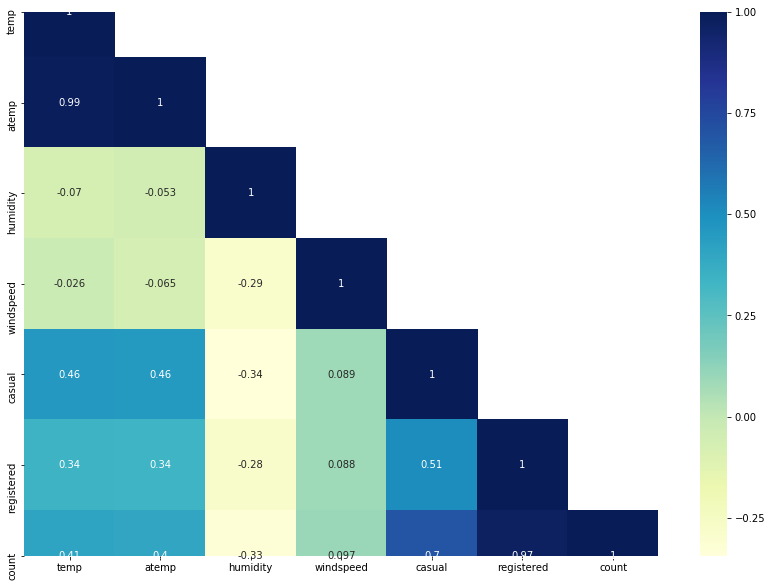

In [13]:
data_corr = df_train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
mask = np.array(data_corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(15, 10))
sn.heatmap(data_corr, mask=mask, vmax=1, square=True, annot=True, cmap="YlGnBu")

It can be observed that:
- `temp` and `atemp` are strongly correlated. To reduce the dimensionality of the predictive model, the feature `atemp` is dismissed.

 I can see in first column, `temp` with `atemp`(in row) have `0.99`,are highly correlated. Remove atemp. 


- `casual` and `registered` contain direct information about the bike sharing `count` which we want to predict (data leakage).

 `casual` and `registered` is exactly what you are trying to predict,because `casual`+`registered`=`count`


- `windspeed` has little correlation with `count`.

 `Windspeed` correlation with count is so low(0.097) that we won’t even consider it in our model. We can remove it too.
 

- `temp` has positive correlation and `humidity` has negative correlation with `count`.

In [14]:
df_train = df_train.drop(['atemp', 'windspeed'], axis=1)

In [15]:
#df_train = df_train.drop(['casual', 'registered'], axis=1)

Analyze the change in bike sharing pattern (`count` variable) with categorical variables:

`sn` Correlation of two feature(`count` and categorical features).

`nrows`=8, create 8 diagramas (because categorical features are 8)

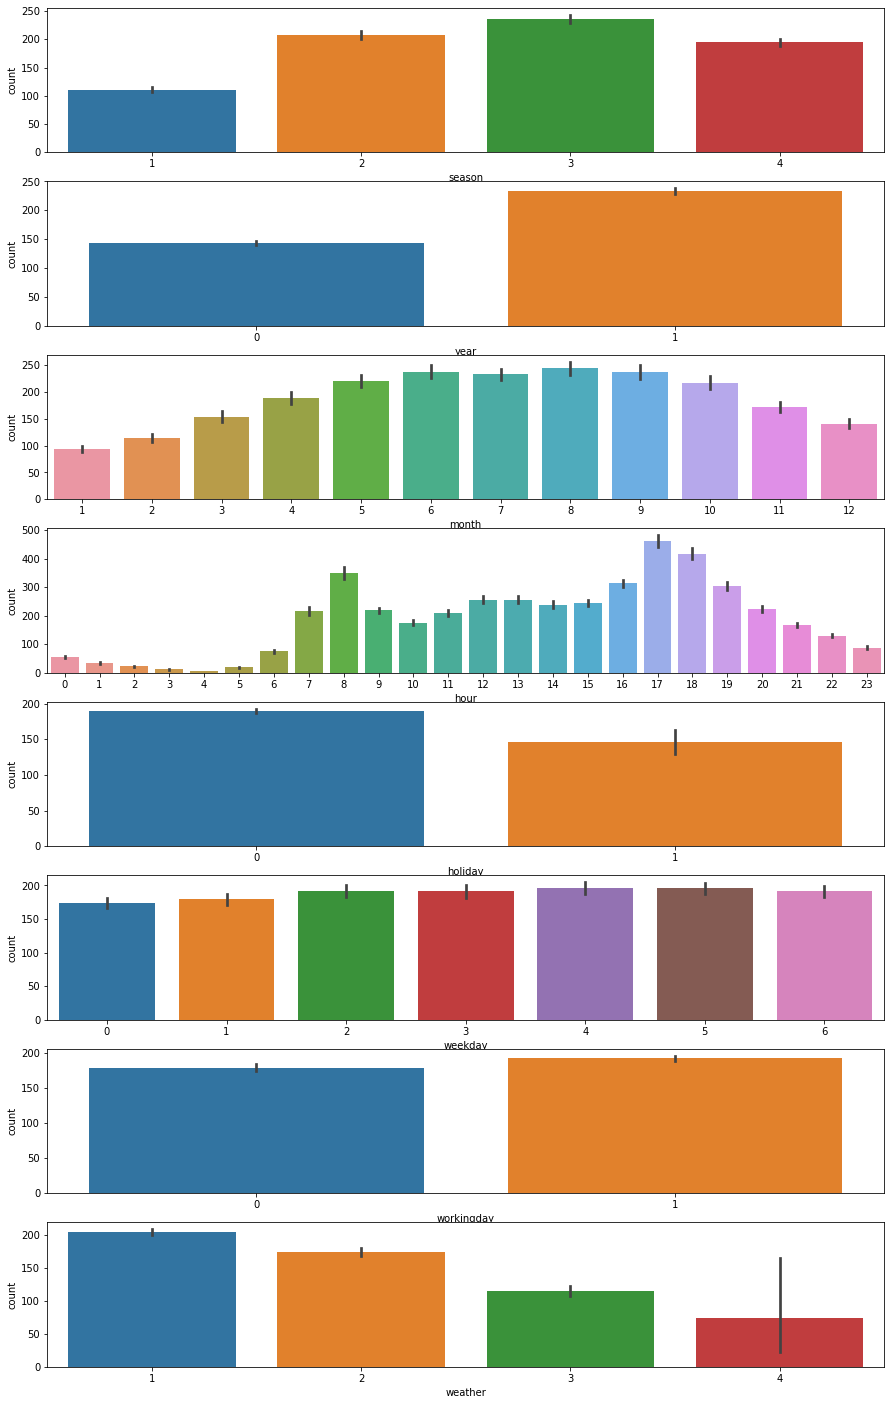

In [16]:
fig,[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8] = plt.subplots(nrows=8, figsize=(15,25))
sn.barplot(x = df_train['season'], y = df_train['count'],ax = ax1)
sn.barplot(x = df_train['year'], y = df_train['count'],ax = ax2)
sn.barplot(x = df_train['month'], y = df_train['count'],ax = ax3)
sn.barplot(x = df_train['hour'], y = df_train['count'],ax = ax4)
sn.barplot(x = df_train['holiday'], y = df_train['count'],ax = ax5)
sn.barplot(x = df_train['weekday'], y = df_train['count'],ax = ax6)
sn.barplot(x = df_train['workingday'], y = df_train['count'],ax = ax7)
sn.barplot(x = df_train['weather'], y = df_train['count'],ax = ax8)

It can be observed that:
- If we use the `weekday` attribute instead of `workingday` (binary value) then results improve a bit. Also, we observed that the workingday parameter, when not taken, does not give much change in result.
- We remove `weather_4`(highly varience=έχει υψηλη διακυμανση, big divergence=μεγαλη αποκλιση), people usually don't take bike when weather is very bad, but it has exeption and take. This case is outliers

Try, but there was no improvement at score:
- We can disregard the significantly high correlation between `weather` and `huminity` since it is only natural for them to have high correlation.Because when they have high huminity is probably rain(bad weather)
- We can disregard the significantly high correlation between `season` and `month` since it is only natural for them to have high correlation.

Analyzing Outliers:

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Hour Of The Day')]

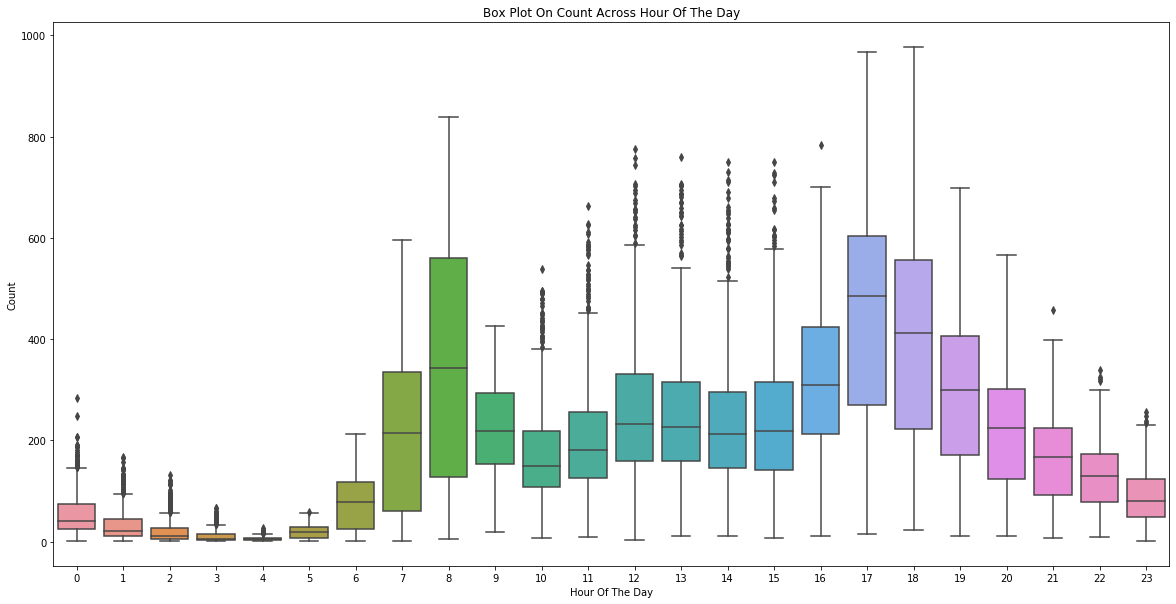

In [17]:
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(20, 10)
sn.boxplot(data=df_train,y="count",x="hour",orient="v",ax=axes)
axes.set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")

Above, we can see that people use more bikes between 7 - 8 and 17 - 18 o'clock, which can be related to the time of day when people go or come back from work or school.

The points on top are outliers.

Removing Outliers in `count`:

In [18]:
print ("Shape before delete Ouliers: ",df_train.shape)

Shape before delete Ouliers:  (12165, 13)


In [19]:
df_train = df_train[np.abs(df_train["count"]-df_train["count"].mean())<=(3*df_train["count"].std())]

In [20]:
print ("Shape after delete Ouliers: ",df_train.shape)

Shape after delete Ouliers:  (11989, 13)


#  <span style="color:SlateBlue"> Predict Count Sharing Bike (Training Models) </span>

# RMSLE Score

In this particular competition, the metric to evaluate your model is **Root Mean Square Logarithmic Error** (RMSLE). It is particularly helpful when we want to penalize an under-predicted estimate greater than an over-predicted estimate. If $\hat{y_i}$ is the predicted value of the $I$-th sample, and ${y_i}$ is the corresponding true value, then the RMSLE estimated over $N$ samples is defined as:

$$ RMSLE = \sqrt{\frac{1}{N} \sum_{i=1}^N (\log(1+\hat{y_i}) - \log(1+y_i))^2 } $$

# Model building

# 1)Trees

## Initialize Feature

Some data types need to be changed from numerical to categorical in order for the model to interpret better these variables:

In [21]:
df_train_Forest['season'] = df_train_Forest.season.astype('category')
df_train_Forest['year'] = df_train_Forest.year.astype('category')
df_train_Forest['month'] = df_train_Forest.month.astype('category')
df_train_Forest['hour'] = df_train_Forest.hour.astype('category')
df_train_Forest['holiday'] = df_train_Forest.holiday.astype('category')
df_train_Forest['weekday'] = df_train_Forest.weekday.astype('category')
df_train_Forest['workingday'] = df_train_Forest.workingday.astype('category')
df_train_Forest['weather'] = df_train_Forest.weather.astype('category')

Rounding the continuous float number `temp`, `humidity`(for better `RandomForest`): 

(e.g. 0,34=>0,3 when round is 1)

`RandomForest` with only categories feature(score=0.4)and with no categories(score=0.35)

In [22]:
df_train_Forest=df_train_Forest.round({'humidity': 1,'temp':1,'windspeed':1})
y_Forest = df_train_Forest['count']
X_Forest = df_train_Forest[['humidity','temp','windspeed','season','year','month','hour','weekday','workingday','weather']]
              
X_train_Forest, X_test_Forest, y_train_Forest, y_test_Forest = train_test_split(X_Forest, y_Forest, test_size=0.2, random_state=42)

## i)RandomForest 

GridsSearchCV:

In [23]:
# from sklearn.model_selection import train_test_split, GridSearchCV

# # Random Forest
# rf = RandomForestRegressor(n_jobs=-1, random_state=0)
# parameters = {'n_estimators': [100, 200, 400, 800], 'max_depth': [5, 15, 25]}
# rf_cv = GridSearchCV(rf, parameters, cv=5, n_jobs=-1)
# rf_cv.fit(X_train_Forest, y_train_Forest)

# print (rf_cv.best_params_)

# y_pred_Forest_CV = rf_cv.predict(X_test_Forest)

In [24]:
# print('RMSLE_Forest:', np.sqrt(mean_squared_log_error(y_test_Forest, y_pred_Forest_CV)))

GridSearchCV on RandomForestRegressor gave as best parameters:

    {'max_depth': 15, 'n_estimators': 800}
    
and gave a score of:

    0.35316109498740716

In [25]:
model_Forest = RandomForestRegressor(n_estimators = 800, max_depth = 15, random_state = 12)
reg_Forest = model_Forest
model_Forest.fit(X_train_Forest,y_train_Forest)

# Get the mean absolute error on the validation data :
y_pred_Forest = model_Forest.predict(X_test_Forest)
MAE_Forest = mean_absolute_error(y_test_Forest , y_pred_Forest)

In [26]:
print('RMSLE_Forest:', np.sqrt(mean_squared_log_error(y_test_Forest, y_pred_Forest)))

RMSLE_Forest: 0.35298182229774855


## ii)ExtraTreesRegressor

In [27]:
from sklearn import model_selection
from sklearn.ensemble import ExtraTreesRegressor

GridSearchCV:

In [28]:
# model_Tree = ensemble.ExtraTreesRegressor(n_jobs=-1, random_state=0)
# parameters = {'n_estimators': [100, 200, 400, 800], 'max_depth': [5, 15, 25]}
# mt_cv = GridSearchCV(model_Tree, parameters, cv=5, n_jobs=-1)
# mt_cv.fit(X_train_Forest, y_train_Forest)

# print (rf_cv.best_params_)

# y_pred_Forest = mt_cv.predict(X_test_Forest)

# print('RMSLE_Forest:', np.sqrt(mean_squared_log_error(y_test_Forest, y_pred_Forest)))

GridSearchCV on ExtraTreesRegressor gave as best parameters:

    {'max_depth': 15, 'n_estimators': 800}
    
and gave a score of:

    0.3513426035169288

In [29]:
from sklearn import ensemble
model_Tree = ensemble.ExtraTreesRegressor(n_estimators = 800, max_depth = 15)
reg_Tree = model_Tree
model_Tree.fit(X_train_Forest, y_train_Forest)

y_pred_Tree_CV = model_Tree.predict(X_test_Forest)

print('RMSLE_Forest:', np.sqrt(mean_squared_log_error(y_test_Forest, y_pred_Tree_CV)))

RMSLE_Forest: 0.35243829552225653


## iii) GradientB

https://medium.com/analytics-vidhya/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-2-29e854aaab7d?

In [30]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV
# # Needs 16 hours
# gbm = GradientBoostingRegressor()
# param_grid = { 
#     'n_estimators': [1000,3000,4000],
#     'max_features': ["auto","sqrt","log2",0.6,0.8],
#     'min_samples_leaf':[30,50,70],
#     'min_samples_split':[200,300],
#     'max_depth' : [15,25],
#     'subsample': [0.4,0.8],
#     'learning_rate':[0.1,0.001]
# }
# CV_gbm=GridSearchCV(estimator=gbm,param_grid=param_grid,cv=5, n_jobs=-1)
# CV_gbm.fit(X = X_train_Forest,y = np.log1p(y_train_Forest))
# print (CV_gbm.best_params_)
# y_pred_Forest = CV_gbm.predict(X= X_test_Forest)
# # print ("RMSLE Value: ",rmsle(y_test_Forest,np.exp(y_pred_Forest)))
# print('RMSLE_Forest:', np.sqrt(mean_squared_log_error(y_test_Forest, y_pred_Forest)))

# 2) MLP:

## Initialize Feature

Some data types need to be changed from numerical to categorical in order for the model to interpret better these variables:

In [31]:
df_train['season'] = df_train.season.astype('category')
df_train['year'] = df_train.year.astype('category')
df_train['month'] = df_train.month.astype('category')
df_train['hour'] = df_train.hour.astype('category')
df_train['holiday'] = df_train.holiday.astype('category')
df_train['weekday'] = df_train.weekday.astype('category')
df_train['workingday'] = df_train.workingday.astype('category')
df_train['weather'] = df_train.weather.astype('category')

One hot encoding:

In [32]:
df_train=pd.get_dummies(df_train)

## Useful Libriries:

When a `Dropout` rate of 0.8 is suggested in a paper (retain 80%), this will, in fact, will be a dropout rate of 0.2 (set 20% of inputs to zero).

Creating a dropout layer with a 50% chance of setting inputs to zero.(eg.model.add(Dropout(0.5)))

In [33]:
from keras.layers import Dropout

Layer `Noise`(eg. input layer => model.add(GaussianNoise(0.01, input_shape=(2,))))

In [34]:
from keras.layers import GaussianNoise

`Initializers` helps Initializations define the way to set the initial random weights of Keras layers.

In [35]:
from keras.initializers import RandomNormal

`BatchNormalization`: 

Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

https://keras.io/layers/normalization/?fbclid=IwAR2RTd4vyPaMXLPjh0qPyirb3fKumkw8vkUIDY-e7HjnRogCMIniLKhd__g

Benefits of using BatchNormalization:

- Networks train faster converge much more quickly.

- Allows higher learning rates. Gradient descent usually requires small learning rates for the network to converge.

- Makes weights easier to initialize

- Makes more activation functions viable. Because batch normalization regulates the values going into each activation function, non-linearities that don't seem to work well in deep networks actually become viable again.

- May give better results overall.

https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/?fbclid=IwAR2VngzpCyste4vS4qyhXuc93ZZWhTjj6svE_AXTwKZq5P6e6ur1wVnRl1E

In [36]:
from keras.layers import BatchNormalization

`Optimizer` Adam - A Method for Stochastic Optimization

e.g F(x)=((w*x)....W*X)

    F'(x)=0
    
`learning rate`= how big is step to find minimum on gragh(=F(x)) => the solution

In [37]:
from keras.optimizers import Adam

In [38]:
from keras.optimizers import SGD
from keras.regularizers import l2

### Model

In [39]:
y = df_train['count']
#X = df_train[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','workingday_0','workingday_1','weather_1','weather_2','weather_3','weather_4','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','holiday_0','holiday_1' ]]
X = df_train[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

GridSearchCV:

In [40]:
# # GridSearchCV for MLP 

# from keras.wrappers.scikit_learn import KerasRegressor

# def create_model(neurons = 1, dropout_rate = 0.1, learning_rate=0.1, optimizer= 'Adam'):
#     model = Sequential()
#     model.add(Dense(neurons, input_dim=57, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=12), use_bias = False))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(dropout_rate))
#     #model.add(Dense(80, use_bias = False))
#     #model.add(Dense(40, use_bias = False))
#     model.add(Dense(40, use_bias = False))
#     model.add(Activation('relu'))
#     model.add(Dense(1, activation='relu'))
    
#     model.compile(loss='mse', optimizer= 'adam', metrics=['mse','mae'])
#     return model

# batch_size = [32, 50, 60]
# epochs = [50, 100]
# # optimizer = ['Adam', 'Adamax', 'Nadam']
# learning_rate = [0.008, 0.01]
# #momentum
# dropout_rate = [0.008, 0.01]
# neurons = [120, 60]
# parameters = {'batch_size': batch_size,
#              'epochs': epochs,
# #              'optimizer': optimizer,
#              'dropout_rate': dropout_rate,
#              'learning_rate': learning_rate,
#              'neurons': neurons}


# model_CV = KerasRegressor(create_model, verbose=0)

# model_CV = GridSearchCV(model_CV, parameters, cv=5, n_jobs=-1)

# model_CV.fit(X_train, y_train)

# print (model_CV.best_params_)

# y_pred_CV = model_CV.predict(X_test)

# print('RMSLE_Forest:', np.sqrt(mean_squared_log_error(y_test, y_pred_CV)))

GridSearchCV on modeal gave as best parameters:

    {'batch_size': 60, 'dropout_rate': 0.01, 'epochs': 100, 'learning_rate': 0.008, 'neurons': 120}
    
and gave a score of:

    0.8820762729223331

Make neurotic shape:

In [41]:
model = Sequential()

model.add(Dense(120, input_dim=56, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=12), use_bias = False))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(80, use_bias = False))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(40, use_bias = False))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(12, use_bias = False))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(1, activation='relu'))
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 120)               6720      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120)               480       
_________________________________________________________________
activation_1 (Activation)    (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                9600      
_________________________________________________________________
batch_normalization_2 (Batch (None, 80)                320       
_________________________________________________________________
activation_2 (Activation)    (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                3200      
_____

`mse` = mean absolute error 

mse= $ \frac{1}{n} \mathbf{\Sigma}_{x=1}^{n} (y(x)-t(x))^2$

n= numerous examples (πλήθος παραδειγμάτων)

help site:https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html

In [42]:
model.compile(loss='mse', optimizer=Adam(lr= 0.008), metrics=['mse','mae'])

In [43]:
history = model.fit(X_train, y_train, epochs=100, batch_size=60,  verbose=1, validation_split=0.2)




Train on 7672 samples, validate on 1919 samples
Epoch 1/150





7672/7672 [==============================] - 4s 527us/step - loss: 52106.4681 - mean_squared_error: 52106.4681 - mean_absolute_error: 168.6052 - val_loss: 33314.4371 - val_mean_squared_error: 33314.4371 - val_mean_absolute_error: 136.9102
Epoch 2/150
7672/7672 [==============================] - 1s 150us/step - loss: 27189.1714 - mean_squared_error: 27189.1714 - mean_absolute_error: 120.5429 - val_loss: 6331.8826 - val_mean_squared_error: 6331.8826 - val_mean_absolute_error: 58.7050
Epoch 3/150
7672/7672 [==============================] - 1s 148us/step - loss: 6906.9151 - mean_squared_error: 6906.9151 - mean_absolute_error: 57.9063 - val_loss: 4761.2181 - val_mean_squared_error: 4761.2181 - val_mean_absolute_error: 46.8311
Epoch 4/150
7672/7672 [==============================] - 1s 125us/step - loss: 3026.5087 - mean_squared_error: 3026.5087 - mean_absolute_error: 37.5034 - val_loss: 2321.3795 - val_mean_squared_error: 

Epoch 28/150
7672/7672 [==============================] - 1s 148us/step - loss: 1582.2117 - mean_squared_error: 1582.2117 - mean_absolute_error: 27.0937 - val_loss: 1896.0642 - val_mean_squared_error: 1896.0642 - val_mean_absolute_error: 26.3485
Epoch 29/150
7672/7672 [==============================] - 1s 126us/step - loss: 1550.2440 - mean_squared_error: 1550.2440 - mean_absolute_error: 26.3642 - val_loss: 1802.3461 - val_mean_squared_error: 1802.3461 - val_mean_absolute_error: 25.7053
Epoch 30/150
7672/7672 [==============================] - 1s 160us/step - loss: 1712.5192 - mean_squared_error: 1712.5192 - mean_absolute_error: 27.6878 - val_loss: 2057.5645 - val_mean_squared_error: 2057.5645 - val_mean_absolute_error: 28.0900
Epoch 31/150
7672/7672 [==============================] - 1s 132us/step - loss: 1541.0526 - mean_squared_error: 1541.0526 - mean_absolute_error: 26.5928 - val_loss: 1916.5443 - val_mean_squared_error: 1916.5443 - val_mean_absolute_error: 27.3034
Epoch 32/150
767

7672/7672 [==============================] - 1s 122us/step - loss: 1132.0830 - mean_squared_error: 1132.0830 - mean_absolute_error: 22.9133 - val_loss: 1766.9303 - val_mean_squared_error: 1766.9303 - val_mean_absolute_error: 25.5872
Epoch 62/150
7672/7672 [==============================] - 1s 112us/step - loss: 1090.1610 - mean_squared_error: 1090.1610 - mean_absolute_error: 22.8119 - val_loss: 2113.4425 - val_mean_squared_error: 2113.4425 - val_mean_absolute_error: 28.1549
Epoch 63/150
7672/7672 [==============================] - 1s 113us/step - loss: 1102.5003 - mean_squared_error: 1102.5003 - mean_absolute_error: 22.9310 - val_loss: 1865.5995 - val_mean_squared_error: 1865.5995 - val_mean_absolute_error: 26.6860
Epoch 64/150
7672/7672 [==============================] - 1s 115us/step - loss: 1073.6777 - mean_squared_error: 1073.6777 - mean_absolute_error: 22.6073 - val_loss: 2210.1488 - val_mean_squared_error: 2210.1488 - val_mean_absolute_error: 30.2231
Epoch 65/150
7672/7672 [=====

7672/7672 [==============================] - 1s 121us/step - loss: 884.7833 - mean_squared_error: 884.7833 - mean_absolute_error: 20.1886 - val_loss: 1782.5276 - val_mean_squared_error: 1782.5276 - val_mean_absolute_error: 25.7405
Epoch 95/150
7672/7672 [==============================] - 1s 167us/step - loss: 827.1580 - mean_squared_error: 827.1580 - mean_absolute_error: 19.8986 - val_loss: 1918.3897 - val_mean_squared_error: 1918.3897 - val_mean_absolute_error: 26.7587
Epoch 96/150
7672/7672 [==============================] - 1s 147us/step - loss: 873.9438 - mean_squared_error: 873.9438 - mean_absolute_error: 20.6005 - val_loss: 1954.9687 - val_mean_squared_error: 1954.9687 - val_mean_absolute_error: 27.3181
Epoch 97/150
7672/7672 [==============================] - 1s 128us/step - loss: 845.3615 - mean_squared_error: 845.3615 - mean_absolute_error: 19.8818 - val_loss: 1821.2146 - val_mean_squared_error: 1821.2146 - val_mean_absolute_error: 26.1950
Epoch 98/150
7672/7672 [=============

7672/7672 [==============================] - 1s 115us/step - loss: 795.9129 - mean_squared_error: 795.9129 - mean_absolute_error: 19.4787 - val_loss: 1835.1176 - val_mean_squared_error: 1835.1176 - val_mean_absolute_error: 26.1453
Epoch 128/150
7672/7672 [==============================] - 1s 115us/step - loss: 746.8230 - mean_squared_error: 746.8230 - mean_absolute_error: 19.0601 - val_loss: 1874.5178 - val_mean_squared_error: 1874.5178 - val_mean_absolute_error: 26.2098
Epoch 129/150
7672/7672 [==============================] - 1s 114us/step - loss: 749.9381 - mean_squared_error: 749.9381 - mean_absolute_error: 18.9629 - val_loss: 1956.1346 - val_mean_squared_error: 1956.1346 - val_mean_absolute_error: 26.9700
Epoch 130/150
7672/7672 [==============================] - 1s 110us/step - loss: 787.4742 - mean_squared_error: 787.4742 - mean_absolute_error: 19.3295 - val_loss: 2482.3860 - val_mean_squared_error: 2482.3860 - val_mean_absolute_error: 30.8608
Epoch 131/150
7672/7672 [=========

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


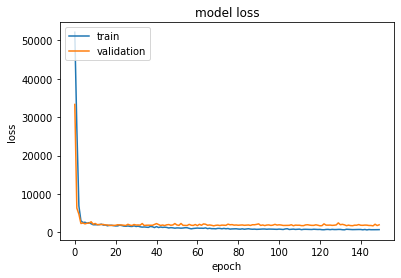

In [44]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
y_pred = model.predict(X_test)

In [46]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

RMSLE: 0.44105771851164943


### Split Dataset and make multiple Models:

#### K-Fold

https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f

![title](K-fold.png)

It has method `sklearn.model_selection.KFold`, but we do hardcode.

Split all df_train in 5 sets which a set has 20% of data(tuples):

In [47]:
start=0
temp                = int(2*(df_train.shape[0]/10))
to=temp
#print(to)
train_part_1    = df_train[start:to][:]
#print(train_part_1) 

start=to
to+=temp
train_part_2    = df_train[start:to][:] 

start=to
to+=temp
train_part_3    = df_train[start:to][:]
start=to
to+=temp
train_part_4    = df_train[start:to][:] 

start=to
to+=temp
train_part_5    = df_train[start:to][:]
 

#### Model 1

Take set 2,3,4,5 for train and set 1 for test:

 `concat()` train_parts which are pandas dataFrames 
 
 https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
 

In [48]:
temp1 = [train_part_2, train_part_3, train_part_4, train_part_5]
train_model_1 = pd.concat(temp1)

temp1 = [train_part_1]
test_model_1 = pd.concat(temp1)

In [49]:
y_train_model_1 = train_model_1['count']
X_train_model_1 = train_model_1[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

In [50]:
y_test_model_1 = test_model_1['count']
X_test_model_1 = test_model_1[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

In [51]:
X_train_model_1.shape

(9588, 56)

In [52]:
X_test_model_1.shape

(2397, 56)

Make neurotic shape:

In [53]:
model_Split_1 = Sequential()
#model.add(Dense(120, input_dim=35, kernel_initializer='normal', activation='relu'))

#model.add(GaussianNoise(0.01, input_shape=(59,)))
#model.add(Dense(120, activation='relu'))

model_Split_1.add(Dense(120, input_dim=56, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=12), use_bias = False))
model_Split_1.add(BatchNormalization())
model_Split_1.add(Activation('relu'))
model_Split_1.add(GaussianNoise(0.01))
model_Split_1.add(Dropout(0.01))

model_Split_1.add(Dense(80, use_bias = False))
model_Split_1.add(BatchNormalization())
model_Split_1.add(Activation('relu'))

#model.add(Dropout(0.1))

model_Split_1.add(Dense(40, use_bias = False))
model_Split_1.add(BatchNormalization())
model_Split_1.add(Activation('relu'))

model_Split_1.add(Dense(12, use_bias = False))
model_Split_1.add(BatchNormalization())
model_Split_1.add(Activation('relu'))

model_Split_1.add(Dense(1, activation='relu'))
model_Split_1.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 120)               6720      
_________________________________________________________________
batch_normalization_5 (Batch (None, 120)               480       
_________________________________________________________________
activation_5 (Activation)    (None, 120)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 80)                9600      
___________________________

In [54]:
model_Split_1.compile(loss='mse', optimizer=Adam(lr= 0.008), metrics=['mse','mae'])

In [55]:
history_model_1 = model_Split_1.fit(X_train_model_1, y_train_model_1, epochs=100, batch_size=60,  verbose=1, validation_split=0.2)

Train on 7670 samples, validate on 1918 samples
Epoch 1/150
7670/7670 [==============================] - 4s 502us/step - loss: 53813.1298 - mean_squared_error: 53813.1298 - mean_absolute_error: 170.9444 - val_loss: 23549.2026 - val_mean_squared_error: 23549.2026 - val_mean_absolute_error: 113.1601
Epoch 2/150
7670/7670 [==============================] - 1s 143us/step - loss: 27897.1836 - mean_squared_error: 27897.1836 - mean_absolute_error: 122.1963 - val_loss: 6772.7065 - val_mean_squared_error: 6772.7065 - val_mean_absolute_error: 58.4780
Epoch 3/150
7670/7670 [==============================] - 1s 144us/step - loss: 6561.3529 - mean_squared_error: 6561.3529 - mean_absolute_error: 56.2452 - val_loss: 5467.8852 - val_mean_squared_error: 5467.8852 - val_mean_absolute_error: 48.4477
Epoch 4/150
7670/7670 [==============================] - 1s 139us/step - loss: 3181.5031 - mean_squared_error: 3181.5031 - mean_absolute_error: 38.4631 - val_loss: 3030.9484 - val_mean_squared_error: 3030.948

7670/7670 [==============================] - 1s 147us/step - loss: 1557.9431 - mean_squared_error: 1557.9431 - mean_absolute_error: 26.8683 - val_loss: 1853.9161 - val_mean_squared_error: 1853.9161 - val_mean_absolute_error: 25.9245
Epoch 35/150
7670/7670 [==============================] - 1s 137us/step - loss: 1464.9317 - mean_squared_error: 1464.9317 - mean_absolute_error: 26.2443 - val_loss: 1915.8637 - val_mean_squared_error: 1915.8637 - val_mean_absolute_error: 26.5064
Epoch 36/150
7670/7670 [==============================] - 1s 131us/step - loss: 1428.5270 - mean_squared_error: 1428.5270 - mean_absolute_error: 25.8505 - val_loss: 1980.2440 - val_mean_squared_error: 1980.2440 - val_mean_absolute_error: 26.9248
Epoch 37/150
7670/7670 [==============================] - 1s 142us/step - loss: 1413.5901 - mean_squared_error: 1413.5901 - mean_absolute_error: 25.7031 - val_loss: 1823.5894 - val_mean_squared_error: 1823.5894 - val_mean_absolute_error: 25.4480
Epoch 38/150
7670/7670 [=====

7670/7670 [==============================] - 1s 145us/step - loss: 933.9992 - mean_squared_error: 933.9992 - mean_absolute_error: 21.2995 - val_loss: 1937.4102 - val_mean_squared_error: 1937.4102 - val_mean_absolute_error: 26.0926
Epoch 68/150
7670/7670 [==============================] - 1s 131us/step - loss: 1036.7043 - mean_squared_error: 1036.7043 - mean_absolute_error: 22.0762 - val_loss: 2300.1205 - val_mean_squared_error: 2300.1205 - val_mean_absolute_error: 28.6683
Epoch 69/150
7670/7670 [==============================] - 1s 177us/step - loss: 962.8633 - mean_squared_error: 962.8633 - mean_absolute_error: 21.6576 - val_loss: 1989.4094 - val_mean_squared_error: 1989.4094 - val_mean_absolute_error: 26.7256
Epoch 70/150
7670/7670 [==============================] - 2s 218us/step - loss: 1052.8373 - mean_squared_error: 1052.8373 - mean_absolute_error: 22.4139 - val_loss: 1950.8993 - val_mean_squared_error: 1950.8993 - val_mean_absolute_error: 26.5806
Epoch 71/150
7670/7670 [=========

7670/7670 [==============================] - 1s 138us/step - loss: 889.9709 - mean_squared_error: 889.9709 - mean_absolute_error: 20.9805 - val_loss: 2075.7986 - val_mean_squared_error: 2075.7986 - val_mean_absolute_error: 27.1815
Epoch 101/150
7670/7670 [==============================] - 1s 141us/step - loss: 789.4877 - mean_squared_error: 789.4877 - mean_absolute_error: 19.7743 - val_loss: 1879.7259 - val_mean_squared_error: 1879.7259 - val_mean_absolute_error: 26.0684
Epoch 102/150
7670/7670 [==============================] - 1s 139us/step - loss: 830.3838 - mean_squared_error: 830.3838 - mean_absolute_error: 19.9512 - val_loss: 2034.0195 - val_mean_squared_error: 2034.0195 - val_mean_absolute_error: 26.8014
Epoch 103/150
7670/7670 [==============================] - 1s 139us/step - loss: 857.4288 - mean_squared_error: 857.4288 - mean_absolute_error: 20.4680 - val_loss: 1879.3008 - val_mean_squared_error: 1879.3008 - val_mean_absolute_error: 26.0588
Epoch 104/150
7670/7670 [=========

7670/7670 [==============================] - 1s 146us/step - loss: 838.7252 - mean_squared_error: 838.7252 - mean_absolute_error: 19.9108 - val_loss: 1837.2226 - val_mean_squared_error: 1837.2226 - val_mean_absolute_error: 25.6839
Epoch 134/150
7670/7670 [==============================] - 1s 142us/step - loss: 815.2297 - mean_squared_error: 815.2297 - mean_absolute_error: 19.9386 - val_loss: 1821.8889 - val_mean_squared_error: 1821.8889 - val_mean_absolute_error: 25.3513
Epoch 135/150
7670/7670 [==============================] - 1s 150us/step - loss: 738.7435 - mean_squared_error: 738.7435 - mean_absolute_error: 19.0431 - val_loss: 2016.1973 - val_mean_squared_error: 2016.1973 - val_mean_absolute_error: 26.6945
Epoch 136/150
7670/7670 [==============================] - 1s 137us/step - loss: 768.2502 - mean_squared_error: 768.2502 - mean_absolute_error: 19.3778 - val_loss: 1956.4939 - val_mean_squared_error: 1956.4939 - val_mean_absolute_error: 26.5488
Epoch 137/150
7670/7670 [=========

In [56]:
y_pred_model_1 = model_Split_1.predict(X_test_model_1)

In [57]:
print('RMSLE model 1:', np.sqrt(mean_squared_log_error(y_test_model_1, y_pred_model_1)))

RMSLE model 1: 0.397551309436881


#### Model 2

Take set 1,3,4,5 for train and set 2 for test:

 `concat()` train_parts which are pandas dataFrames 
 
 https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [58]:
temp2 = [train_part_1, train_part_3, train_part_4, train_part_5]
train_model_2 = pd.concat(temp2)

temp2 = [train_part_2]
test_model_2 = pd.concat(temp2)

In [59]:
y_train_model_2 = train_model_2['count']
X_train_model_2 = train_model_2[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

In [60]:
y_test_model_2 = test_model_2['count']
X_test_model_2 = test_model_2[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

In [61]:
X_train_model_2.shape

(9588, 56)

Make neurotic shape:

In [62]:
model_Split_2 = Sequential()
#model.add(Dense(120, input_dim=35, kernel_initializer='normal', activation='relu'))

#model.add(GaussianNoise(0.01, input_shape=(59,)))
#model.add(Dense(120, activation='relu'))

model_Split_2.add(Dense(120, input_dim=56, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=12), use_bias = False))
model_Split_2.add(BatchNormalization())
model_Split_2.add(Activation('relu'))
model_Split_2.add(GaussianNoise(0.01))
model_Split_2.add(Dropout(0.01))

model_Split_2.add(Dense(80, use_bias = False))
model_Split_2.add(BatchNormalization())
model_Split_2.add(Activation('relu'))

#model.add(Dropout(0.1))

model_Split_2.add(Dense(40, use_bias = False))
model_Split_2.add(BatchNormalization())
model_Split_2.add(Activation('relu'))

model_Split_2.add(Dense(12, use_bias = False))
model_Split_2.add(BatchNormalization())
model_Split_2.add(Activation('relu'))

model_Split_2.add(Dense(1, activation='relu'))
model_Split_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 120)               6720      
_________________________________________________________________
batch_normalization_9 (Batch (None, 120)               480       
_________________________________________________________________
activation_9 (Activation)    (None, 120)               0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 120)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 80)                9600      
_________________________________________________________________
batch_normalization_10 (Batc (None, 80)                320       
__________

In [63]:
model_Split_2.compile(loss='mse', optimizer=Adam(lr= 0.008), metrics=['mse','mae'])

In [64]:
history_model_2 = model_Split_2.fit(X_train_model_2, y_train_model_2, epochs=100, batch_size=60,  verbose=1, validation_split=0.2)

Train on 7670 samples, validate on 1918 samples
Epoch 1/150
7670/7670 [==============================] - 4s 576us/step - loss: 53616.4107 - mean_squared_error: 53616.4107 - mean_absolute_error: 171.3133 - val_loss: 29092.8613 - val_mean_squared_error: 29092.8613 - val_mean_absolute_error: 129.3838
Epoch 2/150
7670/7670 [==============================] - 1s 146us/step - loss: 27728.0367 - mean_squared_error: 27728.0367 - mean_absolute_error: 122.5367 - val_loss: 5714.9381 - val_mean_squared_error: 5714.9381 - val_mean_absolute_error: 55.0134
Epoch 3/150
7670/7670 [==============================] - 1s 141us/step - loss: 6977.0180 - mean_squared_error: 6977.0180 - mean_absolute_error: 59.0544 - val_loss: 5444.8009 - val_mean_squared_error: 5444.8009 - val_mean_absolute_error: 48.4722
Epoch 4/150
7670/7670 [==============================] - 1s 142us/step - loss: 3117.7950 - mean_squared_error: 3117.7950 - mean_absolute_error: 38.1369 - val_loss: 2898.2022 - val_mean_squared_error: 2898.202

7670/7670 [==============================] - 1s 145us/step - loss: 1381.2984 - mean_squared_error: 1381.2984 - mean_absolute_error: 25.6564 - val_loss: 1946.4919 - val_mean_squared_error: 1946.4919 - val_mean_absolute_error: 26.2812
Epoch 35/150
7670/7670 [==============================] - 1s 144us/step - loss: 1354.5435 - mean_squared_error: 1354.5435 - mean_absolute_error: 25.1614 - val_loss: 1898.1650 - val_mean_squared_error: 1898.1650 - val_mean_absolute_error: 26.2368
Epoch 36/150
7670/7670 [==============================] - 1s 143us/step - loss: 1450.0407 - mean_squared_error: 1450.0407 - mean_absolute_error: 26.2546 - val_loss: 1819.8653 - val_mean_squared_error: 1819.8653 - val_mean_absolute_error: 25.1085
Epoch 37/150
7670/7670 [==============================] - 1s 143us/step - loss: 1464.9307 - mean_squared_error: 1464.9307 - mean_absolute_error: 26.0554 - val_loss: 1850.4502 - val_mean_squared_error: 1850.4502 - val_mean_absolute_error: 27.0297
Epoch 38/150
7670/7670 [=====

7670/7670 [==============================] - 2s 237us/step - loss: 1063.0652 - mean_squared_error: 1063.0652 - mean_absolute_error: 22.3117 - val_loss: 1995.0578 - val_mean_squared_error: 1995.0578 - val_mean_absolute_error: 27.3148
Epoch 68/150
7670/7670 [==============================] - 2s 211us/step - loss: 1044.1875 - mean_squared_error: 1044.1875 - mean_absolute_error: 22.1983 - val_loss: 1862.5345 - val_mean_squared_error: 1862.5345 - val_mean_absolute_error: 25.9134
Epoch 69/150
7670/7670 [==============================] - 2s 226us/step - loss: 951.3464 - mean_squared_error: 951.3464 - mean_absolute_error: 21.3305 - val_loss: 1750.8109 - val_mean_squared_error: 1750.8109 - val_mean_absolute_error: 24.8425
Epoch 70/150
7670/7670 [==============================] - 2s 201us/step - loss: 1172.6642 - mean_squared_error: 1172.6642 - mean_absolute_error: 23.7784 - val_loss: 1796.3364 - val_mean_squared_error: 1796.3364 - val_mean_absolute_error: 25.3295
Epoch 71/150
7670/7670 [=======

7670/7670 [==============================] - 2s 199us/step - loss: 1075.1957 - mean_squared_error: 1075.1957 - mean_absolute_error: 22.4850 - val_loss: 2179.8378 - val_mean_squared_error: 2179.8378 - val_mean_absolute_error: 28.0377
Epoch 101/150
7670/7670 [==============================] - 1s 194us/step - loss: 919.6018 - mean_squared_error: 919.6018 - mean_absolute_error: 21.0527 - val_loss: 1886.4141 - val_mean_squared_error: 1886.4141 - val_mean_absolute_error: 25.8939
Epoch 102/150
7670/7670 [==============================] - 1s 186us/step - loss: 962.7369 - mean_squared_error: 962.7369 - mean_absolute_error: 21.4248 - val_loss: 1812.0666 - val_mean_squared_error: 1812.0666 - val_mean_absolute_error: 25.4165
Epoch 103/150
7670/7670 [==============================] - 1s 171us/step - loss: 947.0406 - mean_squared_error: 947.0406 - mean_absolute_error: 21.0760 - val_loss: 2197.8999 - val_mean_squared_error: 2197.8999 - val_mean_absolute_error: 28.3064
Epoch 104/150
7670/7670 [=======

7670/7670 [==============================] - 2s 198us/step - loss: 813.2498 - mean_squared_error: 813.2498 - mean_absolute_error: 19.6383 - val_loss: 1952.1581 - val_mean_squared_error: 1952.1581 - val_mean_absolute_error: 26.4275
Epoch 134/150
7670/7670 [==============================] - 1s 185us/step - loss: 821.7444 - mean_squared_error: 821.7444 - mean_absolute_error: 19.8965 - val_loss: 1920.3325 - val_mean_squared_error: 1920.3325 - val_mean_absolute_error: 26.5508
Epoch 135/150
7670/7670 [==============================] - 1s 179us/step - loss: 851.1453 - mean_squared_error: 851.1453 - mean_absolute_error: 20.3785 - val_loss: 1965.2370 - val_mean_squared_error: 1965.2370 - val_mean_absolute_error: 26.2569
Epoch 136/150
7670/7670 [==============================] - 2s 200us/step - loss: 796.1836 - mean_squared_error: 796.1836 - mean_absolute_error: 19.6432 - val_loss: 1935.4613 - val_mean_squared_error: 1935.4613 - val_mean_absolute_error: 26.2824
Epoch 137/150
7670/7670 [=========

In [65]:
y_pred_model_2 = model_Split_2.predict(X_test_model_2)

In [66]:
print('RMSLE model 2:', np.sqrt(mean_squared_log_error(y_test_model_2, y_pred_model_2)))

RMSLE model 2: 0.39800747859593033


#### Model 3

Take set 1,2,4,5 for train and set 3 for test:

 `concat()` train_parts which are pandas dataFrames 
 
 https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [67]:
temp3 = [train_part_1, train_part_2, train_part_4, train_part_5]
train_model_3 = pd.concat(temp3)

temp3 = [train_part_3]
test_model_3= pd.concat(temp3)

In [68]:
y_train_model_3 = train_model_3['count']
X_train_model_3 = train_model_3[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

y_test_model_3 = test_model_3['count']
X_test_model_3 = test_model_3[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

In [69]:
X_train_model_3.shape

(9588, 56)

Make neurotic shape:

In [70]:
model_Split_3 = Sequential()
#model.add(Dense(120, input_dim=35, kernel_initializer='normal', activation='relu'))

#model.add(GaussianNoise(0.01, input_shape=(59,)))
#model.add(Dense(120, activation='relu'))

model_Split_3.add(Dense(120, input_dim=56, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=12), use_bias = False))
model_Split_3.add(BatchNormalization())
model_Split_3.add(Activation('relu'))
model_Split_3.add(GaussianNoise(0.01))
model_Split_3.add(Dropout(0.01))

model_Split_3.add(Dense(80, use_bias = False))
model_Split_3.add(BatchNormalization())
model_Split_3.add(Activation('relu'))

#model.add(Dropout(0.1))

model_Split_3.add(Dense(40, use_bias = False))
model_Split_3.add(BatchNormalization())
model_Split_3.add(Activation('relu'))

model_Split_3.add(Dense(12, use_bias = False))
model_Split_3.add(BatchNormalization())
model_Split_3.add(Activation('relu'))

model_Split_3.add(Dense(1, activation='relu'))
model_Split_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 120)               6720      
_________________________________________________________________
batch_normalization_13 (Batc (None, 120)               480       
_________________________________________________________________
activation_13 (Activation)   (None, 120)               0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 120)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 80)                9600      
_________________________________________________________________
batch_normalization_14 (Batc (None, 80)                320       
__________

In [71]:
model_Split_3.compile(loss='mse', optimizer=Adam(lr= 0.008), metrics=['mse','mae'])

In [72]:
history_model_3 = model_Split_3.fit(X_train_model_3, y_train_model_3, epochs=100, batch_size=60,  verbose=1, validation_split=0.2)

Train on 7670 samples, validate on 1918 samples
Epoch 1/150
7670/7670 [==============================] - 6s 757us/step - loss: 55281.6278 - mean_squared_error: 55281.6278 - mean_absolute_error: 173.5048 - val_loss: 36187.0072 - val_mean_squared_error: 36187.0072 - val_mean_absolute_error: 141.7636
Epoch 2/150
7670/7670 [==============================] - 2s 209us/step - loss: 35159.4891 - mean_squared_error: 35159.4891 - mean_absolute_error: 138.0014 - val_loss: 5874.6905 - val_mean_squared_error: 5874.6905 - val_mean_absolute_error: 57.0694
Epoch 3/150
7670/7670 [==============================] - 2s 248us/step - loss: 10552.0678 - mean_squared_error: 10552.0678 - mean_absolute_error: 72.1326 - val_loss: 4549.9020 - val_mean_squared_error: 4549.9020 - val_mean_absolute_error: 47.2254
Epoch 4/150
7670/7670 [==============================] - 2s 219us/step - loss: 3201.2534 - mean_squared_error: 3201.2534 - mean_absolute_error: 38.6327 - val_loss: 5095.9686 - val_mean_squared_error: 5095.9

7670/7670 [==============================] - 2s 218us/step - loss: 1489.1666 - mean_squared_error: 1489.1666 - mean_absolute_error: 26.4955 - val_loss: 1993.7571 - val_mean_squared_error: 1993.7571 - val_mean_absolute_error: 27.1908
Epoch 35/150
7670/7670 [==============================] - 2s 245us/step - loss: 1475.6724 - mean_squared_error: 1475.6724 - mean_absolute_error: 26.6205 - val_loss: 2243.2727 - val_mean_squared_error: 2243.2727 - val_mean_absolute_error: 29.4794
Epoch 36/150
7670/7670 [==============================] - 2s 273us/step - loss: 1407.4044 - mean_squared_error: 1407.4044 - mean_absolute_error: 25.8683 - val_loss: 1957.5635 - val_mean_squared_error: 1957.5635 - val_mean_absolute_error: 26.4098
Epoch 37/150
7670/7670 [==============================] - 2s 255us/step - loss: 1522.2193 - mean_squared_error: 1522.2193 - mean_absolute_error: 26.9655 - val_loss: 1984.2580 - val_mean_squared_error: 1984.2580 - val_mean_absolute_error: 27.2013
Epoch 38/150
7670/7670 [=====

7670/7670 [==============================] - 1s 158us/step - loss: 945.5672 - mean_squared_error: 945.5672 - mean_absolute_error: 21.4312 - val_loss: 2145.3398 - val_mean_squared_error: 2145.3398 - val_mean_absolute_error: 28.0665
Epoch 68/150
7670/7670 [==============================] - 1s 162us/step - loss: 928.8180 - mean_squared_error: 928.8180 - mean_absolute_error: 21.4646 - val_loss: 1993.8921 - val_mean_squared_error: 1993.8921 - val_mean_absolute_error: 27.2410
Epoch 69/150
7670/7670 [==============================] - 1s 154us/step - loss: 961.1023 - mean_squared_error: 961.1023 - mean_absolute_error: 21.8854 - val_loss: 2039.7627 - val_mean_squared_error: 2039.7627 - val_mean_absolute_error: 27.1968
Epoch 70/150
7670/7670 [==============================] - 1s 161us/step - loss: 1042.4801 - mean_squared_error: 1042.4801 - mean_absolute_error: 22.1997 - val_loss: 2255.6027 - val_mean_squared_error: 2255.6027 - val_mean_absolute_error: 28.9331
Epoch 71/150
7670/7670 [===========

Epoch 101/150
7670/7670 [==============================] - 1s 164us/step - loss: 801.5839 - mean_squared_error: 801.5839 - mean_absolute_error: 19.8416 - val_loss: 1959.8585 - val_mean_squared_error: 1959.8585 - val_mean_absolute_error: 26.0382
Epoch 102/150
7670/7670 [==============================] - 1s 155us/step - loss: 840.1344 - mean_squared_error: 840.1344 - mean_absolute_error: 19.9452 - val_loss: 2057.7797 - val_mean_squared_error: 2057.7797 - val_mean_absolute_error: 27.4042
Epoch 103/150
7670/7670 [==============================] - 1s 156us/step - loss: 824.2970 - mean_squared_error: 824.2970 - mean_absolute_error: 19.8806 - val_loss: 2010.3224 - val_mean_squared_error: 2010.3224 - val_mean_absolute_error: 26.7413
Epoch 104/150
7670/7670 [==============================] - 1s 160us/step - loss: 738.3668 - mean_squared_error: 738.3668 - mean_absolute_error: 18.7919 - val_loss: 2016.5627 - val_mean_squared_error: 2016.5627 - val_mean_absolute_error: 26.8617
Epoch 105/150
7670/7

7670/7670 [==============================] - 2s 204us/step - loss: 721.7187 - mean_squared_error: 721.7187 - mean_absolute_error: 18.7621 - val_loss: 1891.5531 - val_mean_squared_error: 1891.5531 - val_mean_absolute_error: 25.9398
Epoch 135/150
7670/7670 [==============================] - 2s 198us/step - loss: 708.7227 - mean_squared_error: 708.7227 - mean_absolute_error: 18.7565 - val_loss: 2245.5997 - val_mean_squared_error: 2245.5997 - val_mean_absolute_error: 28.9330
Epoch 136/150
7670/7670 [==============================] - 1s 187us/step - loss: 751.4679 - mean_squared_error: 751.4679 - mean_absolute_error: 19.0642 - val_loss: 1956.9614 - val_mean_squared_error: 1956.9614 - val_mean_absolute_error: 26.6835
Epoch 137/150
7670/7670 [==============================] - 1s 186us/step - loss: 725.1336 - mean_squared_error: 725.1336 - mean_absolute_error: 18.5457 - val_loss: 1961.5751 - val_mean_squared_error: 1961.5751 - val_mean_absolute_error: 26.3760
Epoch 138/150
7670/7670 [=========

In [73]:
y_pred_model_3 = model_Split_3.predict(X_test_model_3)

In [74]:
print('RMSLE model 3:', np.sqrt(mean_squared_log_error(y_test_model_3, y_pred_model_3)))

RMSLE model 3: 0.3984451612412788


#### Model 4

Take set 1,2,3,5 for train and set 4 for test:

 `concat()` train_parts which are pandas dataFrames 
 
 https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [75]:
temp4 = [train_part_1, train_part_2, train_part_3, train_part_5]
train_model_4 = pd.concat(temp4)

temp4 = [train_part_4]
test_model_4= pd.concat(temp4)

In [76]:
y_train_model_4 = train_model_4['count']
X_train_model_4 = train_model_4[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

y_test_model_4 = test_model_4['count']
X_test_model_4 = test_model_4[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

In [77]:
X_train_model_4.shape

(9588, 56)

Make neurotic shape:

In [78]:
model_Split_4 = Sequential()
#model.add(Dense(120, input_dim=35, kernel_initializer='normal', activation='relu'))

#model.add(GaussianNoise(0.01, input_shape=(59,)))
#model.add(Dense(120, activation='relu'))

model_Split_4.add(Dense(120, input_dim=56, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=12), use_bias = False))
model_Split_4.add(BatchNormalization())
model_Split_4.add(Activation('relu'))
model_Split_4.add(GaussianNoise(0.01))
model_Split_4.add(Dropout(0.01))

model_Split_4.add(Dense(80, use_bias = False))
model_Split_4.add(BatchNormalization())
model_Split_4.add(Activation('relu'))

#model.add(Dropout(0.1))

model_Split_4.add(Dense(40, use_bias = False))
model_Split_4.add(BatchNormalization())
model_Split_4.add(Activation('relu'))

model_Split_4.add(Dense(12, use_bias = False))
model_Split_4.add(BatchNormalization())
model_Split_4.add(Activation('relu'))

model_Split_4.add(Dense(1, activation='relu'))
model_Split_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 120)               6720      
_________________________________________________________________
batch_normalization_17 (Batc (None, 120)               480       
_________________________________________________________________
activation_17 (Activation)   (None, 120)               0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 120)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 80)                9600      
_________________________________________________________________
batch_normalization_18 (Batc (None, 80)                320       
__________

In [79]:
model_Split_4.compile(loss='mse', optimizer=Adam(lr= 0.008), metrics=['mse','mae'])

In [80]:
model_Split_4.fit(X_train_model_4, y_train_model_4, epochs=100, batch_size=60,  verbose=1, validation_split=0.2)

Train on 7670 samples, validate on 1918 samples
Epoch 1/150
7670/7670 [==============================] - 6s 774us/step - loss: 52863.0197 - mean_squared_error: 52863.0197 - mean_absolute_error: 170.6779 - val_loss: 32874.3889 - val_mean_squared_error: 32874.3889 - val_mean_absolute_error: 136.3329
Epoch 2/150
7670/7670 [==============================] - 2s 209us/step - loss: 29770.0837 - mean_squared_error: 29770.0837 - mean_absolute_error: 127.4532 - val_loss: 8333.1399 - val_mean_squared_error: 8333.1399 - val_mean_absolute_error: 69.4990
Epoch 3/150
7670/7670 [==============================] - 1s 193us/step - loss: 8449.1740 - mean_squared_error: 8449.1740 - mean_absolute_error: 64.1317 - val_loss: 6522.3644 - val_mean_squared_error: 6522.3644 - val_mean_absolute_error: 52.9545
Epoch 4/150
7670/7670 [==============================] - 2s 205us/step - loss: 3198.2255 - mean_squared_error: 3198.2255 - mean_absolute_error: 38.8442 - val_loss: 4206.5761 - val_mean_squared_error: 4206.576

7670/7670 [==============================] - 1s 191us/step - loss: 1452.8643 - mean_squared_error: 1452.8643 - mean_absolute_error: 26.2037 - val_loss: 1959.2666 - val_mean_squared_error: 1959.2666 - val_mean_absolute_error: 26.8896
Epoch 35/150
7670/7670 [==============================] - 2s 223us/step - loss: 1526.7191 - mean_squared_error: 1526.7191 - mean_absolute_error: 27.0182 - val_loss: 2279.7249 - val_mean_squared_error: 2279.7249 - val_mean_absolute_error: 29.3420
Epoch 36/150
7670/7670 [==============================] - 2s 212us/step - loss: 1452.7964 - mean_squared_error: 1452.7964 - mean_absolute_error: 26.5286 - val_loss: 2343.5529 - val_mean_squared_error: 2343.5529 - val_mean_absolute_error: 29.9468
Epoch 37/150
7670/7670 [==============================] - 2s 237us/step - loss: 1428.9294 - mean_squared_error: 1428.9294 - mean_absolute_error: 25.9422 - val_loss: 2027.7904 - val_mean_squared_error: 2027.7904 - val_mean_absolute_error: 27.3422
Epoch 38/150
7670/7670 [=====

7670/7670 [==============================] - 2s 225us/step - loss: 1005.3214 - mean_squared_error: 1005.3214 - mean_absolute_error: 22.1226 - val_loss: 2041.4931 - val_mean_squared_error: 2041.4931 - val_mean_absolute_error: 26.6038
Epoch 68/150
7670/7670 [==============================] - 2s 236us/step - loss: 1011.3497 - mean_squared_error: 1011.3497 - mean_absolute_error: 22.4891 - val_loss: 1967.8091 - val_mean_squared_error: 1967.8091 - val_mean_absolute_error: 26.9406
Epoch 69/150
7670/7670 [==============================] - 2s 233us/step - loss: 1030.4966 - mean_squared_error: 1030.4966 - mean_absolute_error: 22.3020 - val_loss: 2138.0385 - val_mean_squared_error: 2138.0385 - val_mean_absolute_error: 27.6518
Epoch 70/150
7670/7670 [==============================] - 2s 264us/step - loss: 1105.0334 - mean_squared_error: 1105.0334 - mean_absolute_error: 22.9421 - val_loss: 2214.6353 - val_mean_squared_error: 2214.6353 - val_mean_absolute_error: 28.28927 - mean_squared_error: 1084.7

7670/7670 [==============================] - 2s 211us/step - loss: 828.9107 - mean_squared_error: 828.9107 - mean_absolute_error: 19.8583 - val_loss: 2239.4884 - val_mean_squared_error: 2239.4884 - val_mean_absolute_error: 28.9160
Epoch 101/150
7670/7670 [==============================] - 2s 239us/step - loss: 832.5840 - mean_squared_error: 832.5840 - mean_absolute_error: 20.0552 - val_loss: 2011.6280 - val_mean_squared_error: 2011.6280 - val_mean_absolute_error: 26.8018
Epoch 102/150
7670/7670 [==============================] - 2s 207us/step - loss: 834.8954 - mean_squared_error: 834.8954 - mean_absolute_error: 20.2231 - val_loss: 1993.5668 - val_mean_squared_error: 1993.5668 - val_mean_absolute_error: 26.4605
Epoch 103/150
7670/7670 [==============================] - 2s 224us/step - loss: 801.7206 - mean_squared_error: 801.7206 - mean_absolute_error: 19.7413 - val_loss: 2134.8015 - val_mean_squared_error: 2134.8015 - val_mean_absolute_error: 27.4799
Epoch 104/150
7670/7670 [=========

7670/7670 [==============================] - 2s 265us/step - loss: 750.4245 - mean_squared_error: 750.4245 - mean_absolute_error: 19.1428 - val_loss: 2030.5063 - val_mean_squared_error: 2030.5063 - val_mean_absolute_error: 26.7359
Epoch 134/150
7670/7670 [==============================] - 2s 231us/step - loss: 793.4828 - mean_squared_error: 793.4828 - mean_absolute_error: 19.3709 - val_loss: 2040.9574 - val_mean_squared_error: 2040.9574 - val_mean_absolute_error: 26.7963
Epoch 135/150
7670/7670 [==============================] - 2s 273us/step - loss: 708.1098 - mean_squared_error: 708.1098 - mean_absolute_error: 18.6867 - val_loss: 1963.1557 - val_mean_squared_error: 1963.1557 - val_mean_absolute_error: 26.2022
Epoch 136/150
7670/7670 [==============================] - 2s 262us/step - loss: 802.7416 - mean_squared_error: 802.7416 - mean_absolute_error: 19.5468 - val_loss: 2111.1987 - val_mean_squared_error: 2111.1987 - val_mean_absolute_error: 27.3220
Epoch 137/150
7670/7670 [=========

In [81]:
y_pred_model_4 = model_Split_4.predict(X_test_model_4)

In [82]:
print('RMSLE model 4:', np.sqrt(mean_squared_log_error(y_test_model_4, y_pred_model_4)))

RMSLE model 4: 0.4117507093835228


#### Model 5

Take set 1,2,3,4 for train and set 5 for test:

 `concat()` train_parts which are pandas dataFrames 
 
 https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [83]:
temp5 = [train_part_1, train_part_2, train_part_3, train_part_4]
train_model_5 = pd.concat(temp5)

temp5 = [train_part_5]
test_model_5= pd.concat(temp5)

In [84]:
y_train_model_5 = train_model_5['count']
X_train_model_5 = train_model_5[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

y_test_model_5 = test_model_5['count']
X_test_model_5 = test_model_5[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

In [85]:
X_train_model_5.shape

(9588, 56)

Make neurotic shape:

In [86]:
model_Split_5 = Sequential()
#model.add(Dense(120, input_dim=35, kernel_initializer='normal', activation='relu'))

#model.add(GaussianNoise(0.01, input_shape=(59,)))
#model.add(Dense(120, activation='relu'))

model_Split_5.add(Dense(120, input_dim=56, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=12), use_bias = False))
model_Split_5.add(BatchNormalization())
model_Split_5.add(Activation('relu'))
model_Split_5.add(GaussianNoise(0.01))
model_Split_5.add(Dropout(0.01))

model_Split_5.add(Dense(80, use_bias = False))
model_Split_5.add(BatchNormalization())
model_Split_5.add(Activation('relu'))

#model.add(Dropout(0.1))

model_Split_5.add(Dense(40, use_bias = False))
model_Split_5.add(BatchNormalization())
model_Split_5.add(Activation('relu'))

model_Split_5.add(Dense(12, use_bias = False))
model_Split_5.add(BatchNormalization())
model_Split_5.add(Activation('relu'))

model_Split_5.add(Dense(1, activation='relu'))
model_Split_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 120)               6720      
_________________________________________________________________
batch_normalization_21 (Batc (None, 120)               480       
_________________________________________________________________
activation_21 (Activation)   (None, 120)               0         
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 120)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 80)                9600      
_________________________________________________________________
batch_normalization_22 (Batc (None, 80)                320       
__________

In [87]:
model_Split_5.compile(loss='mse', optimizer=Adam(lr= 0.008), metrics=['mse','mae'])

In [88]:
model_Split_5.fit(X_train_model_5, y_train_model_5, epochs=100, batch_size=60,  verbose=1, validation_split=0.2)

Train on 7670 samples, validate on 1918 samples
Epoch 1/150
7670/7670 [==============================] - 7s 881us/step - loss: 54894.0513 - mean_squared_error: 54894.0513 - mean_absolute_error: 173.1925 - val_loss: 38775.1984 - val_mean_squared_error: 38775.1984 - val_mean_absolute_error: 147.0210
Epoch 2/150
7670/7670 [==============================] - 2s 225us/step - loss: 32539.9774 - mean_squared_error: 32539.9774 - mean_absolute_error: 132.1292 - val_loss: 6467.6992 - val_mean_squared_error: 6467.6992 - val_mean_absolute_error: 60.6818
Epoch 3/150
7670/7670 [==============================] - 2s 253us/step - loss: 8945.8278 - mean_squared_error: 8945.8278 - mean_absolute_error: 66.1115 - val_loss: 3548.6888 - val_mean_squared_error: 3548.6888 - val_mean_absolute_error: 41.6477
Epoch 4/150
7670/7670 [==============================] - 2s 241us/step - loss: 3250.2813 - mean_squared_error: 3250.2813 - mean_absolute_error: 39.6756 - val_loss: 2866.3678 - val_mean_squared_error: 2866.367

Epoch 34/150
7670/7670 [==============================] - 2s 244us/step - loss: 1388.9196 - mean_squared_error: 1388.9196 - mean_absolute_error: 25.0028 - val_loss: 1932.8805 - val_mean_squared_error: 1932.8805 - val_mean_absolute_error: 27.2385
Epoch 35/150
7670/7670 [==============================] - 2s 277us/step - loss: 1328.4079 - mean_squared_error: 1328.4079 - mean_absolute_error: 24.5561 - val_loss: 1839.3751 - val_mean_squared_error: 1839.3751 - val_mean_absolute_error: 26.0776
Epoch 36/150
7670/7670 [==============================] - 2s 303us/step - loss: 1489.1207 - mean_squared_error: 1489.1207 - mean_absolute_error: 25.9600 - val_loss: 1724.2319 - val_mean_squared_error: 1724.2319 - val_mean_absolute_error: 25.4257
Epoch 37/150
7670/7670 [==============================] - 2s 269us/step - loss: 1306.7033 - mean_squared_error: 1306.7033 - mean_absolute_error: 24.5750 - val_loss: 1719.3763 - val_mean_squared_error: 1719.3763 - val_mean_absolute_error: 25.3475
Epoch 38/150
767

7670/7670 [==============================] - 2s 233us/step - loss: 1109.4409 - mean_squared_error: 1109.4409 - mean_absolute_error: 22.7024 - val_loss: 1760.2296 - val_mean_squared_error: 1760.2296 - val_mean_absolute_error: 25.8292
Epoch 68/150
7670/7670 [==============================] - 3s 328us/step - loss: 989.3267 - mean_squared_error: 989.3267 - mean_absolute_error: 21.3382 - val_loss: 1798.8738 - val_mean_squared_error: 1798.8738 - val_mean_absolute_error: 26.3162
Epoch 69/150
7670/7670 [==============================] - 2s 257us/step - loss: 1022.1172 - mean_squared_error: 1022.1172 - mean_absolute_error: 21.8927 - val_loss: 1951.2657 - val_mean_squared_error: 1951.2657 - val_mean_absolute_error: 27.5017
Epoch 70/150
7670/7670 [==============================] - 2s 234us/step - loss: 909.2994 - mean_squared_error: 909.2994 - mean_absolute_error: 20.7820 - val_loss: 1814.7030 - val_mean_squared_error: 1814.7030 - val_mean_absolute_error: 26.1180
Epoch 71/150
7670/7670 [=========

7670/7670 [==============================] - 2s 315us/step - loss: 770.2585 - mean_squared_error: 770.2585 - mean_absolute_error: 19.0712 - val_loss: 1661.5067 - val_mean_squared_error: 1661.5067 - val_mean_absolute_error: 25.2090
Epoch 101/150
7670/7670 [==============================] - 2s 271us/step - loss: 747.0892 - mean_squared_error: 747.0892 - mean_absolute_error: 18.8049 - val_loss: 1907.3063 - val_mean_squared_error: 1907.3063 - val_mean_absolute_error: 26.9978
Epoch 102/150
7670/7670 [==============================] - 2s 259us/step - loss: 829.5246 - mean_squared_error: 829.5246 - mean_absolute_error: 19.7208 - val_loss: 1757.1844 - val_mean_squared_error: 1757.1844 - val_mean_absolute_error: 26.4716
Epoch 103/150
7670/7670 [==============================] - 3s 422us/step - loss: 808.3519 - mean_squared_error: 808.3519 - mean_absolute_error: 19.5720 - val_loss: 1645.5411 - val_mean_squared_error: 1645.5411 - val_mean_absolute_error: 25.5396
Epoch 104/150
7670/7670 [=========

7670/7670 [==============================] - 3s 326us/step - loss: 668.3778 - mean_squared_error: 668.3778 - mean_absolute_error: 17.7432 - val_loss: 1732.6688 - val_mean_squared_error: 1732.6688 - val_mean_absolute_error: 25.8477
Epoch 134/150
7670/7670 [==============================] - 2s 302us/step - loss: 700.9396 - mean_squared_error: 700.9396 - mean_absolute_error: 18.3077 - val_loss: 1866.1290 - val_mean_squared_error: 1866.1290 - val_mean_absolute_error: 26.7139
Epoch 135/150
7670/7670 [==============================] - 2s 324us/step - loss: 666.5493 - mean_squared_error: 666.5493 - mean_absolute_error: 17.6842 - val_loss: 1766.2543 - val_mean_squared_error: 1766.2543 - val_mean_absolute_error: 26.2871
Epoch 136/150
7670/7670 [==============================] - 2s 311us/step - loss: 651.2669 - mean_squared_error: 651.2669 - mean_absolute_error: 17.6068 - val_loss: 2168.1891 - val_mean_squared_error: 2168.1891 - val_mean_absolute_error: 29.0192
Epoch 137/150
7670/7670 [=========

In [89]:
y_pred_model_5 = model_Split_5.predict(X_test_model_5)

In [90]:
print('RMSLE model 5:', np.sqrt(mean_squared_log_error(y_test_model_5, y_pred_model_5)))

RMSLE model 5: 0.36276893517130754


# Predict register

In [91]:
# df_train_registered = pd.read_csv('train.csv')

In [92]:
# df_train_registered.rename(columns={'weathersit':'weather',
#                      'mnth':'month',
#                      'hr':'hour',
#                      'yr':'year',
#                      'hum': 'humidity',
#                      'cnt':'count'},inplace=True)

In [93]:
# df_train_registered = shuffle(df_train_registered, random_state=42)

In [94]:
# df_train_registered['season'] = df_train_registered.season.astype('category')
# df_train_registered['year'] = df_train_registered.year.astype('category')
# df_train_registered['month'] = df_train_registered.month.astype('category')
# df_train_registered['hour'] = df_train_registered.hour.astype('category')
# df_train_registered['holiday'] = df_train_registered.holiday.astype('category')
# df_train_registered['weekday'] = df_train_registered.weekday.astype('category')
# df_train_registered['workingday'] = df_train_registered.workingday.astype('category')
# df_train_registered['weather'] = df_train_registered.weather.astype('category')

In [95]:
# features_r = ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather']
# #Separating out the features
# X_r = df_train_registered.loc[:, features_r].values
# #Separating out the target
# y_r = df_train_registered.loc[:,['registered']].values
# #Standardizing the features
# X_r = StandardScaler().fit_transform(X_r)

In [96]:
#X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

In [97]:
# model_rf = RandomForestRegressor()
# model_rf.fit(X_train_r,y_train_r)

# # Get the mean absolute error on the validation data :
# y_pred_r = model_rf.predict(X_test_r)
# MAE_r = mean_absolute_error(y_test_r , y_pred_r)

In [98]:
# y_pred_r = model_rf.predict(X_test_r)

In [99]:
# print('RMSLE pred reg:', np.sqrt(mean_squared_log_error(y_test_r, y_pred_r)))

In [100]:
# df_train_model_r = pd.read_csv('train.csv')

In [101]:
# df_train_model_r.rename(columns={'weathersit':'weather',
#                      'mnth':'month',
#                      'hr':'hour',
#                      'yr':'year',
#                      'hum': 'humidity',
#                      'cnt':'count'},inplace=True)

In [102]:
# df_train_model_r = shuffle(df_train_model_r, random_state=42)

In [103]:
# df_train_model_r['season'] = df_train_model_r.season.astype('category')
# df_train_model_r['year'] = df_train_model_r.year.astype('category')
# df_train_model_r['month'] = df_train_model_r.month.astype('category')
# df_train_model_r['hour'] = df_train_model_r.hour.astype('category')
# df_train_model_r['holiday'] = df_train_model_r.holiday.astype('category')
# df_train_model_r['weekday'] = df_train_model_r.weekday.astype('category')
# df_train_model_r['workingday'] = df_train_model_r.workingday.astype('category')
# df_train_model_r['weather'] = df_train_model_r.weather.astype('category')

In [104]:
# df_train_model_r = df_train_model_r.drop(['windspeed','atemp'], axis=1)

In [105]:
# df_train_model_r=pd.get_dummies(df_train_model_r)

In [106]:
# y_model_r = df_train_model_r['count']
# X_model_r = df_train_model_r[['season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','workingday_0','workingday_1','weather_1','weather_2','weather_3','weather_4','temp', 'humidity','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','holiday_0','holiday_1','registered' ]]

# X_train_model_r, X_test_model_r, y_train_model_r, y_test_model_r = train_test_split(X_model_r, y_model_r, test_size=0.2, random_state=42)

In [107]:
# X_test_model_r = X_test_model_r.drop([ 'registered'], axis=1)

H `.shape[0]` επιστρέφει το πόσα row είναι στο dataFrame
και η `.index` πέρνει τον νούμερο του row και με την `range` του λέει να το κάνει από 0 εώς .shape[0]

In [108]:
# X_test_model_r.index = range(X_test_model_r.shape[0])

Χρησιμοποιούμε την `pd.concat()`για να ενώσουμε columns (δηλαδή `axis=1`) από δυο πίνακες σε ένα dataframe.'Oμως, η `y_pred_c`,`y_pred_r` που προβλέπουμε πιο πάνω είναι σε μορφή np.array,ενώ `df_train` που θέλουμε να τις προσθέσουμε μέσα είναι dataFrame. Οπότε χρησιμοποιούμε την `pd.DataFrame()` για να μετατρέψουμε το array σε dataFrame.

By default η pd.concat() το array που βάζει του δίνει όνομα 0,οπότε για να ξεχωρίζουμε τα feature τα κάνουμε `rename()` σε `pred_casual`,`pred_registered` αντίστοιχα,αμέσως μετά concat(για να μην μπερδεφτουν τα 0)

In [109]:
# X_test_model_r = pd.concat([X_test_model_r, pd.DataFrame(y_pred_r)], axis=1)
# X_test_model_r.rename(columns={0:'registered'},inplace=True)

In [110]:
# model_r = Sequential()
# model_r.add(Dense(120, input_dim=60, kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=12), activation='relu'))
# #model.add(Dense(120, input_dim=59, kernel_initializer='normal', activation='relu'))
# model_r.add(Dense(80, activation='relu'))
# model_r.add(Dense(40, activation='relu'))
# model_r.add(Dense(12, activation='relu'))
# model_r.add(Dense(1, activation='relu'))
# model_r.summary()

In [111]:
# model_r.compile(loss='mse',optimizer='adam', metrics=['mse','mae'])

In [112]:
# model_r.fit(X_train_model_r, y_train_model_r, epochs=50, batch_size=50,  verbose=1, validation_split=0.2)

In [113]:
# y_pred_model_r = model_r.predict(X_test_model_r)

In [114]:
# print('RMSLE:', np.sqrt(mean_squared_log_error(y_test_model_r, y_pred_model_r)))

# <span style="color:SlateBlue"> Code for Kaggle </span>

In [115]:
filename = 'test.csv' 

df_test = pd.read_csv(filename)
df_test_Forest = pd.read_csv(filename)

In [116]:
df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)
df_test_Forest.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

In [117]:
df_test['season'] = df_test.season.astype('category')
df_test['year'] = df_test.year.astype('category')
df_test['month'] = df_test.month.astype('category')
df_test['hour'] = df_test.hour.astype('category')
df_test['holiday'] = df_test.holiday.astype('category')
df_test['weekday'] = df_test.weekday.astype('category')
df_test['workingday'] = df_test.workingday.astype('category')
df_test['weather'] = df_test.weather.astype('category')

df_test_Forest['season'] = df_test_Forest.season.astype('category')
df_test_Forest['year'] = df_test_Forest.year.astype('category')
df_test_Forest['month'] = df_test_Forest.month.astype('category')
df_test_Forest['hour'] = df_test_Forest.hour.astype('category')
df_test_Forest['holiday'] = df_test_Forest.holiday.astype('category')
df_test_Forest['weekday'] = df_test_Forest.weekday.astype('category')
df_test_Forest['workingday'] = df_test_Forest.workingday.astype('category')
df_test_Forest['weather'] = df_test_Forest.weather.astype('category')

### Trees predict Test

In [118]:
df_test_Forest=df_test_Forest.round({'humidity': 1,'temp':1,'windspeed':1})

In [119]:
df_test_Forest = df_test_Forest[['humidity','temp','windspeed','season','year','month','hour','weekday','workingday','weather']]   

RandomForest:

In [120]:
y_pred_Forest = model_Forest.predict(df_test_Forest)

ExtraTreesRegressor:

In [121]:
y_pred_Tree = model_Tree.predict(df_test_Forest)

### MLP predict Test

In [122]:
df_test=pd.get_dummies(df_test)

In [123]:
df_test = df_test[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','weather_1','weather_2','weather_3','holiday_0','holiday_1']]

Model:

In [124]:
y_pred = model.predict(df_test)

Model 1:

In [125]:
y_pred_model_1 = model_Split_1.predict(df_test)

Molel 2:

In [126]:
y_pred_model_2 = model_Split_2.predict(df_test)

Model 3:

In [127]:
y_pred_model_3 = model_Split_3.predict(df_test)

Model 4:

In [128]:
y_pred_model_4 = model_Split_4.predict(df_test)

Model 5:

In [129]:
y_pred_model_5 = model_Split_5.predict(df_test)

#### Model register:

In [130]:
# df_test_R= pd.read_csv('test.csv')

In [131]:
# df_test_R.rename(columns={'weathersit':'weather',
#                      'mnth':'month',
#                      'hr':'hour',
#                      'yr':'year',
#                      'hum': 'humidity',
#                      'cnt':'count'},inplace=True)

In [132]:
# df_test_R['season'] = df_test_R.season.astype('category')
# df_test_R['year'] = df_test_R.year.astype('category')
# df_test_R['month'] = df_test_R.month.astype('category')
# df_test_R['hour'] = df_test_R.hour.astype('category')
# df_test_R['holiday'] = df_test_R.holiday.astype('category')
# df_test_R['weekday'] = df_test_R.weekday.astype('category')
# df_test_R['workingday'] = df_test_R.workingday.astype('category')
# df_test_R['weather'] = df_test_R.weather.astype('category')

In [133]:
# df_test_R=pd.get_dummies(df_test_R)

In [134]:
# df_test_R.insert(56,'weather_4',np.uint8(0))

In [135]:
# df_test_r= pd.read_csv('test.csv')

In [136]:
# df_test_r.rename(columns={'weathersit':'weather',
#                      'mnth':'month',
#                      'hr':'hour',
#                      'yr':'year',
#                      'hum': 'humidity',
#                      'cnt':'count'},inplace=True)

In [137]:
# features_r1 = ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather']
# #Separating out the features
# X_r1 = df_test_r.loc[:, features_r1].values
# #Standardizing the features
# X_r1 = StandardScaler().fit_transform(X_r1)

In [138]:
# y_pred_r = model_rf.predict(X_r1)

In [139]:
# df_test_R = df_test_R[['season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','workingday_0','workingday_1','weather_1','weather_2','weather_3','weather_4','temp', 'humidity','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','holiday_0','holiday_1' ]]

In [140]:
# df_test_R=pd.concat([df_test_R, pd.DataFrame(y_pred_r)], axis=1)
# df_test_R.rename(columns={0:'registered'},inplace=True)

In [141]:
# y_pred_model_r = model_r.predict(df_test_R)

# Ensemble learning

From Wikipedia:

Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

KNN

In [142]:
from sklearn.neighbors import KNeighborsRegressor

In [143]:
reg_knn = KNeighborsRegressor(n_jobs=-1, n_neighbors=8, weights='distance', p=1)

#### Voting Regression:

Every model makes a prediction (votes) for each test instance and the final output prediction is the one that receives more than half of the votes.

https://www.toptal.com/machine-learning/ensemble-methods-machine-learning?fbclid=IwAR0Sdsla0Fdxrws0Pblxmy5eIBh2cq8TnGoCXKwlX1DXkYW79UyDNIXb3Bc

In [144]:
from sklearn.ensemble import VotingRegressor

n_jobsint or None, optional (default=None)
The number of jobs to run in parallel for fit. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

In [145]:
voting = VotingRegressor(estimators=[('rf', reg_Forest), ('rt', reg_Tree), ('knn', reg_knn)], weights=[5, 3, 1], n_jobs=-1)
voting.fit(X_train_Forest, y_train_Forest)
y_pred_Voting = voting.predict(X_test_Forest)

True in (y_pred_Voting < 0)
for i, y  in enumerate(y_pred_Voting):
    if y_pred_Voting[i] < 0:
        y_pred_Voting[i] = 0
for i, y  in enumerate(y_pred_Voting):
    if y_pred_Voting[i] < 0:
        y_pred_Voting[i] = 0

print('RMSLE voting:', np.sqrt(mean_squared_log_error(y_test_Forest, y_pred_Voting)))

y_pred_Voting = voting.predict(df_test_Forest)

RMSLE voting: 0.3495248335106671


#### Average:

Average the predictions from RandomForest, Model, Model 1, Model 2, Model 3, Model 4, Model 5.

average: `y_pred_Forest`,
`y_pred`,
`y_pred_model_1`,
`y_pred_model_2`,
`y_pred_model_3`,
`y_pred_model_4`,
`y_pred_model_5`.

In [165]:
y_pred_average = [0]*len(y_pred_model_1)

for i in range(0,len(y_pred)):
    y_pred_average[i] = y_pred_Voting[i] + float(y_pred[i]) + float(y_pred_model_1[i]) + float(y_pred_model_2[i]) + float(y_pred_model_3[i]) + float(y_pred_model_4[i]) + float(y_pred_model_5[i])
    y_pred_average[i] = y_pred_average[i]/7

# Submission Average

In [166]:
submission = pd.DataFrame()
submission['Id'] = range(len(y_pred_average))
submission['Predicted'] = y_pred_average

In [167]:
submission.to_csv("submission.csv", index=False)

# If want make a submission for testing some model

In [149]:
# submission = pd.DataFrame()
# submission['Id'] = range( y_pred_Forest.shape[0])
# submission['Predicted'] =  y_pred_Forest

In [150]:
# submission.to_csv("submissionVoting.csv", index=False)

# Try,and not work

In [151]:
#LOG

# https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c

# df_train.hist('count',figsize=(8,5))
# df_train['count'] = np.log(df_train['count'])
# df_train['count'].describe()



# Percentile Linearization

# size = len(df_train['count'])-1
# df_train['count'] = df_train['count'].rank(method='min').apply(lambda x: (x-1)/size)
# df_train['count'].describe()    GIVES SCORE 1.77



# Log Max Root

# log_max = np.log(df_train['count'].max())
# df_train['count'] = df_train['count']**(1/log_max)
# df_train['count'].describe()#

# Log Max Root Normalized  GIVES SCORE 1.76

# https://towardsdatascience.com/transforming-skewed-data-73da4c2d0d16

# def normalize(column):
#     upper = column.max()
#     lower = column.min()
#     y = (column - lower)/(upper-lower)
#     return y

# df_train['count'] = normalize(df_train['count'])

##################################################################################################

# Reversing log

# y_pred = np.expm1(y_pred)
# y_pred_model_1 = np.expm1(y_pred_model_1)
# y_pred_model_2 = np.expm1(y_pred_model_2)
# y_pred_model_3 = np.expm1(y_pred_model_3)
# y_pred_model_4 = np.expm1(y_pred_model_4)
# y_pred_model_5 = np.expm1(y_pred_model_5)

#### Time Series Analysis(RNN):

In [152]:
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# import pandas as pd
# import seaborn as sns
# from pylab import rcParams
# import matplotlib.pyplot as plt
# from matplotlib import rc
# from sklearn.model_selection import train_test_split
# from pandas.plotting import register_matplotlib_converters

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# register_matplotlib_converters()
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# rcParams['figure.figsize'] = 22, 10

# RANDOM_SEED = 42

# np.random.seed(RANDOM_SEED)
# tf.random.set_seed(RANDOM_SEED)

In [153]:
#df = pd.read_csv("train.csv")

# train_size = int(len(df) * 0.9)
# test_size = len(df) - train_size
# train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
# print(len(train), len(test))

In [154]:
# from sklearn.preprocessing import RobustScaler

# f_columns = ['atemp', 'temp', 'hum', 'windspeed']

# f_transformer = RobustScaler()
# cnt_transformer = RobustScaler()

# f_transformer = f_transformer.fit(train[f_columns].to_numpy())
# cnt_transformer = cnt_transformer.fit(train[['cnt']])

# train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
# train['cnt'] = cnt_transformer.transform(train[['cnt']])

# test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
# test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [155]:
# def create_dataset(X, y, time_steps=1):
#     Xs, ys = [], []
#     for i in range(len(X) - time_steps):
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)        
#         ys.append(y.iloc[i + time_steps])
#     return np.array(Xs), np.array(ys)

In [156]:
# time_steps = 10

# # reshape to [samples, time_steps, n_features]

# X_train, y_train = create_dataset(train, train.cnt, time_steps)
# X_test, y_test = create_dataset(test, test.cnt, time_steps)

# print(X_train.shape, y_train.shape)

In [157]:
# model = keras.Sequential()
# model.add(
#   keras.layers.Bidirectional(
#     keras.layers.LSTM(
#       units=128, 
#       input_shape=(X_train.shape[1], X_train.shape[2])
#     )
#   )
# )
# model.add(keras.layers.Dropout(rate=0.2))
# model.add(keras.layers.Dense(units=1))
# model.compile(loss='mean_squared_error', optimizer='adam')

In [158]:
# history = model.fit(
#     X_train, y_train, 
#     epochs=10, 
#     batch_size=32, 
#     validation_split=0.1,
#     shuffle=False
# )

In [159]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend();

In [160]:
#y_pred = model.predict(X_test)

In [161]:
# y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
# y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
# y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [162]:
# from sklearn.metrics import mean_squared_log_error, r2_score

# True in (y_pred < 0)
# for i, y  in enumerate(y_pred):
#     if y_pred[i] < 0:
#         y_pred[i] = 0
# for i, y  in enumerate(y_pred):
#     if y_pred[i] < 0:
#         y_pred[i] = 0

In [163]:
# print('RMSLE:', np.sqrt(mean_squared_log_error(y_test_inv, y_pred_inv.T)))
# print('R2:', r2_score(y_test_inv, y_pred_inv.T))



#RMSLE: 1.599107832091222
#R2: nan

#### Tanh estimators normalization:

In [164]:
# import pandas as pd
# from sklearn import preprocessing
# from sklearn.preprocessing import MinMaxScaler

# count = df_train[['count']]
# m_count = np.mean(count, axis=0) # array([16.25, 26.25])
# std_count = np.std(count, axis=0) # array([17.45530005, 22.18529919])

# mylist1 = []

# for i in range(len(count)):
#     estimator = 0.5 * (np.tanh(0.01 * ((count['count'][i] - m_count) / std_count)) + 1)
#     mylist1.insert(i, estimator)

    
# df_train_count = pd.DataFrame(mylist1)
# df_train.insert(60,'normalised_count',df_train_count)

# temp = df_train[['temp']]
# m_temp = np.mean(temp, axis=0) 
# std_temp = np.std(temp, axis=0) 

# mylist2 = []

# for i in range(len(temp)):
#     estimator = 0.5 * (np.tanh(0.01 * ((temp['temp'][i] - m_temp) / std_temp)) + 1)
#     mylist2.insert(i, estimator)

# df_train_temp = pd.DataFrame(mylist2)
# df_train.insert(61,'normalised_temp',df_train_count)

# humidity = df_train[['humidity']]
# m_humidity = np.mean(humidity, axis=0) # array([16.25, 26.25])
# std_humidity = np.std(humidity, axis=0) # array([17.45530005, 22.18529919])

# mylist3 = []

# for i in range(len(humidity)):
#     estimator = 0.5 * (np.tanh(0.01 * ((humidity['humidity'][i] - m_humidity) / std_humidity)) + 1)
#     mylist3.insert(i, estimator)
    
# df_train_humidity = pd.DataFrame(mylist3)
# df_train.insert(62,'normalised_humidity',df_train_count)

# y = df_train['normalised_count']
# X = df_train[['temp', 'humidity','season_1','season_2','season_3','season_4','year_0','year_1','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','workingday_0','workingday_1','weather_1','weather_2','weather_3','weather_4','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6' ]]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##################################################################################################################

# Reverse tanh estimator's normalization
# for i in range(len(y_pred)):
#     y1 = y_pred[i] * 2
#     y2 = y1 - 1
#     y3 = np.arctanh(y2)
#     y4 = y3 / 0.01
#     y5 = y4 * std_count
#     y6 = y5 + m_count
#     y_pred[i] = y6.round()